In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pycaret.regression import *

In [48]:
path_arquivos = 'arquivos'
encoding = 'latin2'

In [49]:
df_2010 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2010.csv', encoding=encoding, sep=';')
df_2011 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2011.csv', encoding=encoding, sep=';')
df_2012 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2012.csv', encoding=encoding, sep=';')
df_2013 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2013.csv', encoding=encoding, sep=';')
df_2014 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2014.csv', encoding=encoding, sep=';')
df_2015 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2015.csv', encoding=encoding, sep=';')

df_final = pd.concat([df_2010, df_2011, df_2012, df_2013, df_2014, df_2015],
                     axis=0,
                     ignore_index=True)

# filtrando os dados do RJ e apenas colegios que possuem ensino médio

df_rj = df_final[(df_final['SG_UF'] == 'RJ') & (df_final['IN_MED'] == 1)]

dados_infraestrutura = [
    'NU_ANO_CENSO',
    'CO_ENTIDADE',
    'TP_DEPENDENCIA',
    'SG_UF',
    'IN_BIBLIOTECA_SALA_LEITURA',
    'IN_LABORATORIO_CIENCIAS',
    'IN_AUDITORIO',
    'IN_INTERNET',
    'QT_DOC_MED'
]

df_rj = df_rj[dados_infraestrutura]

In [50]:
# carregando, filtrando e manipulando dados sobre o Enem por escola

df_enem = pd.read_csv(f'{path_arquivos}/MICRODADOS_ENEM_ESCOLA.csv',
                     encoding=encoding,
                     sep=';')

years_to_include = [2010, 2011, 2012, 2013, 2014, 2015]
colunas_selecionadas = ['CO_ESCOLA_EDUCACENSO', 'NU_ANO', 'SG_UF_ESCOLA',
                       'TP_DEPENDENCIA_ADM_ESCOLA', 'NU_TAXA_PARTICIPACAO', 'NU_TAXA_APROVACAO', 'TP_LOCALIZACAO_ESCOLA', 
                       'NU_MEDIA_CN', 'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_MT', 'NU_MEDIA_RED']

df_enem_final = df_enem[
    (df_enem['SG_UF_ESCOLA'] == 'RJ') &
    (df_enem['NU_ANO'].isin(years_to_include))
][colunas_selecionadas].copy()

df_enem_final = df_enem_final.rename(columns={
    'CO_ESCOLA_EDUCACENSO': 'CO_ENTIDADE',
    'NU_ANO': 'NU_ANO_CENSO',
    'SG_UF_ESCOLA': 'SG_UF',
    'TP_DEPENDENCIA_ADM_ESCOLA': 'TP_DEPENDENCIA'
})

In [51]:
notas_competencias = ['NU_MEDIA_CN', 'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_MT', 'NU_MEDIA_RED']

In [52]:
correlacao = df_enem_final[notas_competencias].corr()
print(correlacao)

# boa correlação de pearson entre as competencias -> justificativa para unificar as pontuações em uma unica pontuação

              NU_MEDIA_CN  NU_MEDIA_CH  NU_MEDIA_LP  NU_MEDIA_MT  NU_MEDIA_RED
NU_MEDIA_CN      1.000000     0.885867     0.918387     0.915664      0.834201
NU_MEDIA_CH      0.885867     1.000000     0.845764     0.740300      0.784604
NU_MEDIA_LP      0.918387     0.845764     1.000000     0.859763      0.837568
NU_MEDIA_MT      0.915664     0.740300     0.859763     1.000000      0.793376
NU_MEDIA_RED     0.834201     0.784604     0.837568     0.793376      1.000000


In [53]:
df_enem_final["NOTA_GERAL_ESCOLA"] = df_enem_final[notas_competencias].mean(axis=1)
df_enem_final = df_enem_final.drop(columns=notas_competencias)

# média das competências

In [54]:
# Mesclando o dataset do censo com o dataset do enem por escola

df_completo = pd.merge(
    df_rj,
    df_enem_final,
    how='inner',
    left_on=['CO_ENTIDADE', 'NU_ANO_CENSO'],
    right_on=['CO_ENTIDADE', 'NU_ANO_CENSO']
)

In [55]:
columnsToRemove = [
    'NU_ANO_CENSO',
    'SG_UF_x',
    'CO_ENTIDADE',
    'TP_DEPENDENCIA_y',
    'SG_UF_y'
  ]
df_completo = df_completo.drop(columns=columnsToRemove)

df_completo['TP_DEPENDENCIA_x'] = df_completo['TP_DEPENDENCIA_x'].replace({1: 1, 2: 1, 3: 1, 4: 2})

df = df_completo.dropna()

In [56]:
print("Valores faltantes restantes:")
print(df[['NU_TAXA_APROVACAO', 'NOTA_GERAL_ESCOLA']].isna().sum())

Valores faltantes restantes:
NU_TAXA_APROVACAO    0
NOTA_GERAL_ESCOLA    0
dtype: int64


In [57]:
df_novo = df.drop(columns=['IN_INTERNET', 'TP_LOCALIZACAO_ESCOLA'])

In [60]:
train, test = train_test_split(df_novo, test_size=0.3, random_state=42)

s = setup(train, target='NOTA_GERAL_ESCOLA', session_id=123)

,Description,Value
0,Session id,123
1,Target,NOTA_GERAL_ESCOLA
2,Target type,Regression
3,Original data shape,"(4739, 8)"
4,Transformed data shape,"(4739, 8)"
5,Transformed train set shape,"(3317, 8)"
6,Transformed test set shape,"(1422, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [61]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,25.5884,1149.9706,33.8691,0.6668,0.0608,0.0467,0.0370
lightgbm,Light Gradient Boosting Machine,26.0050,1192.4714,34.5001,0.6543,0.0619,0.0474,0.4530
rf,Random Forest Regressor,26.0931,1221.2372,34.9095,0.6459,0.0625,0.0475,0.0780
et,Extra Trees Regressor,26.8294,1294.2188,35.9321,0.6253,0.0644,0.0489,0.0540
ada,AdaBoost Regressor,29.0075,1362.9705,36.8785,0.6045,0.0666,0.0536,0.0160
lr,Linear Regression,31.7065,1604.4533,39.9939,0.5357,0.0720,0.0580,0.6230
ridge,Ridge Regression,31.7081,1604.4411,39.9938,0.5357,0.0720,0.0580,0.0030
br,Bayesian Ridge,31.7116,1604.4749,39.9943,0.5357,0.0720,0.0580,0.0040
llar,Lasso Least Angle Regression,32.0670,1624.0251,40.2410,0.5301,0.0724,0.0586,0.0040
lasso,Lasso Regression,32.0673,1624.0395,40.2412,0.5301,0.0724,0.0586,0.0040


In [62]:
predictions = predict_model(best_model, data=test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,25.6822,1137.7503,33.7306,0.6595,0.0601,0.0465


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,25.5962,1146.7029,33.8630,0.6563,0.0607,0.0465
1,23.2756,939.6881,30.6543,0.6945,0.0553,0.0428
2,27.3793,1210.5718,34.7933,0.6172,0.0629,0.0505
3,24.3279,993.1602,31.5144,0.7038,0.0570,0.0444
4,24.8138,1130.2594,33.6193,0.6720,0.0606,0.0458
5,25.5917,1170.6505,34.2148,0.6611,0.0611,0.0465
6,27.9395,1300.3101,36.0598,0.6307,0.0654,0.0515
7,24.7014,1163.7171,34.1133,0.6662,0.0604,0.0445
8,24.8169,1117.1480,33.4238,0.7069,0.0600,0.0452


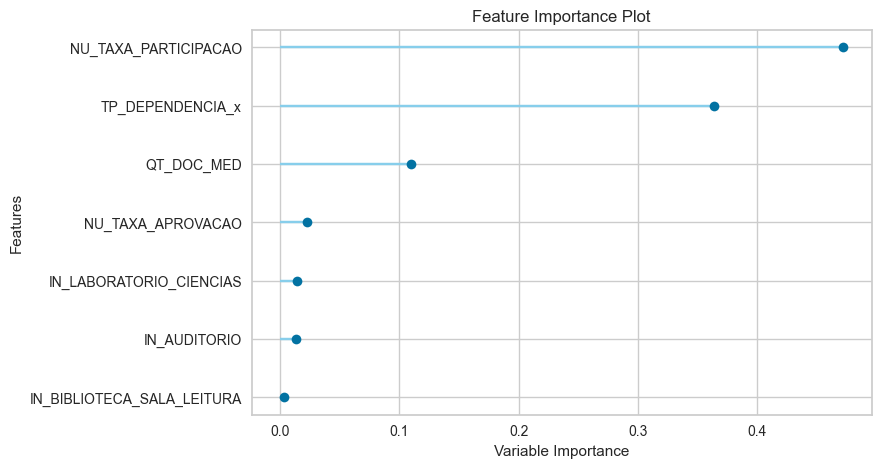

In [63]:
# Criar o modelo (GBR no seu caso)
model = create_model('gbr')

# Plotar feature importance
plot_model(model, plot='feature')

In [64]:
get_config('X_train_transformed').head()

,TP_DEPENDENCIA_x,IN_BIBLIOTECA_SALA_LEITURA,IN_LABORATORIO_CIENCIAS,IN_AUDITORIO,QT_DOC_MED,NU_TAXA_PARTICIPACAO,NU_TAXA_APROVACAO
1098,1.0,1.0,0.0,0.0,59.0,29.000000,59.299999
1357,1.0,1.0,0.0,0.0,55.0,38.799999,79.000000
6097,1.0,1.0,1.0,1.0,32.0,68.570000,77.699997
3083,2.0,1.0,0.0,0.0,12.0,71.430000,100.000000
5846,2.0,1.0,1.0,0.0,14.0,95.239998,94.599998
